In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:13<00:00, 88.8MB/s]
100% 1.14G/1.14G [00:13<00:00, 93.3MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [7]:
batch_size = 32

img_height = 64
img_width = 64

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


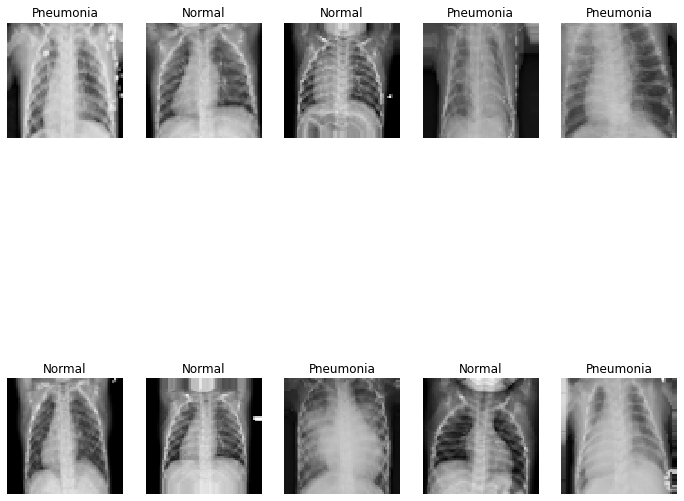

In [10]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [15]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [16]:
# Initialising the CNN
model_3_hidden= Sequential()

# Step 1 - Convolution
model_3_hidden.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model_3_hidden.add(MaxPooling2D(pool_size = (2, 2)))
model_3_hidden.add(Dropout(0.2))
# Adding a second convolutional layer
model_3_hidden.add(Conv2D(32, (3, 3), activation = 'relu'))
model_3_hidden.add(MaxPooling2D(pool_size = (2, 2)))
model_3_hidden.add(Dropout(0.2))
# Adding a third convolutional layer
model_3_hidden.add(Conv2D(32, (3, 3), activation = 'relu'))
model_3_hidden.add(MaxPooling2D(pool_size = (2, 2)))
model_3_hidden.add(Dropout(0.2))
# Step 3 - Flattening
model_3_hidden.add(Flatten())

# Step 4 - Full connection
model_3_hidden.add(Dense(units = 128, activation = 'relu'))
model_3_hidden.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
optim=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_3_hidden.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

#summary
model_3_hidden.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)       

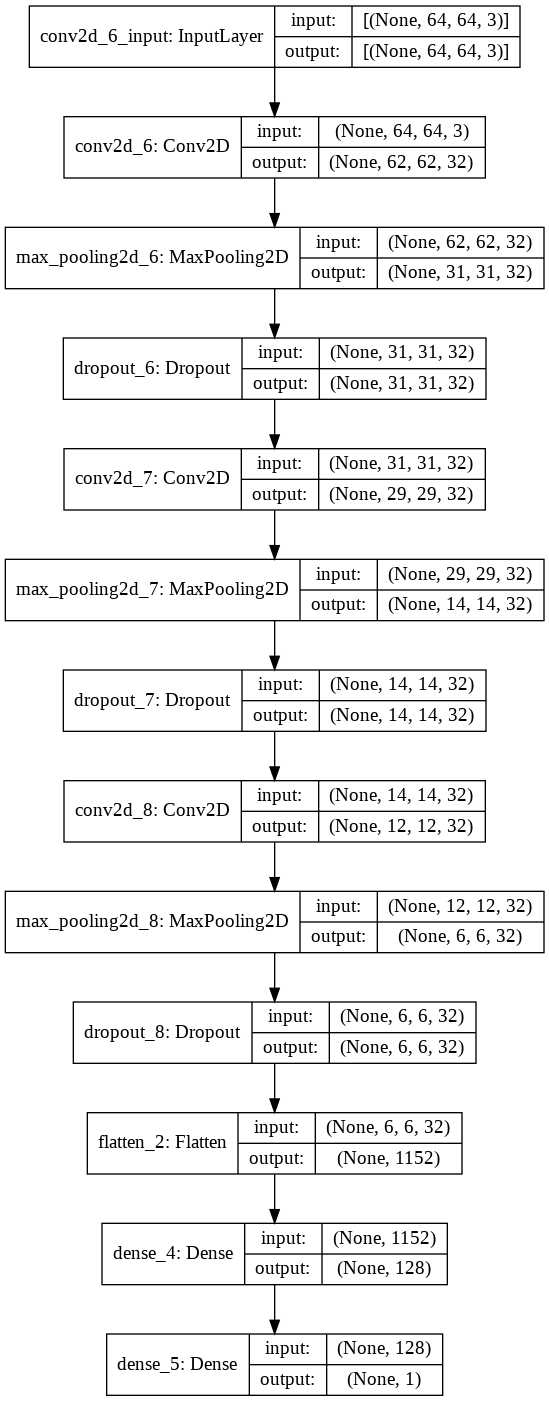

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model_3_hidden,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [18]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [19]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [21]:
model_3_hidden.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
131/131 [==============================] - 79s 595ms/step - loss: 0.6507 - accuracy: 0.6125 - val_loss: 0.6377 - val_accuracy: 0.6423
Epoch 2/25
131/131 [==============================] - 76s 579ms/step - loss: 0.3806 - accuracy: 0.8292 - val_loss: 0.5843 - val_accuracy: 0.6913
Epoch 3/25
131/131 [==============================] - 76s 579ms/step - loss: 0.3372 - accuracy: 0.8632 - val_loss: 0.5711 - val_accuracy: 0.6913
Epoch 4/25
131/131 [==============================] - 76s 581ms/step - loss: 0.2910 - accuracy: 0.8717 - val_loss: 0.5423 - val_accuracy: 0.7183
Epoch 5/25
131/131 [==============================] - 76s 580ms/step - loss: 0.2849 - accuracy: 0.8783 - val_loss: 0.6195 - val_accuracy: 0.6750
Epoch 6/25
131/131 [==============================] - 77s 586ms/step - loss: 0.2353 - accuracy: 0.8968 - val_loss: 0.4021 - val_accuracy: 0.8077
Epoch 7/25
131/131 [==============================] - 76s 584ms/step - loss: 0.2449 - accuracy: 0.8992 - val_loss: 0.2624 - val_ac

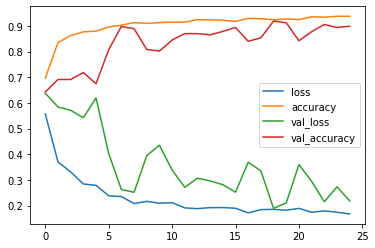

In [23]:
pd.DataFrame(model_3_hidden.history.history).plot()

In [25]:
test_accu = model_3_hidden.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 7s 302ms/step - loss: 0.2199 - accuracy: 0.9151
The testing accuracy is -  91.50640964508057 %
